<a href="https://colab.research.google.com/github/Mahyar-rajabi94/BO_tutorial/blob/main/BO_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing Dependencies

Before we begin, we need to make sure all the required libraries are available.  
In this tutorial, we will use **[BoTorch](https://botorch.org/)**, a library for Bayesian Optimization built on PyTorch.  

Since this notebook may be run in different environments, we first check whether we are running inside **Google Colab**.  
If we are, we use Colab’s built-in `%pip install` magic command to install `botorch`.  
This way, the code remains portable and does not force installation when running outside Colab.



In [3]:
import sys
# Check if running inside Google Colab
if 'google.colab' in sys.modules:
    %pip install botorch

## 2) Load Libraries

In this section we import the libraries used throughout the tutorial.  
These cover **data handling**, **Bayesian optimization with BoTorch**, **evaluation metrics**, **plotting**, and a few **utility** helpers.

> ✅ You already installed `botorch` in Part 1 (Colab check). The rest are common scientific Python packages.

### What this cell sets up
- **Core stack**: `pandas`, `numpy`, `torch`
- **Bayesian Optimization** (BoTorch & GPyTorch):
  - `SingleTaskGP` (Gaussian Process model)
  - `ExactMarginalLogLikelihood` and `fit_gpytorch_mll` (training the GP)
  - `ExpectedImprovement` (acquisition function we’ll optimize)
- **Evaluation metrics**: MAE, MSE, \(R^2\), and **Spearman** correlation
- **Plotting**: `matplotlib.pyplot` for visualizing iterations and results
- **Preprocessing**: `StandardScaler` for feature/target scaling
- **Notebook utilities**: `clear_output`, `display` for smooth updates in Colab/Jupyter
- **General utilities**: `warnings`, `random`, `time`, `os`, `argparse`, `csv`, `pickle`, `sys`

> ℹ️ Tip: If you run this in **Google Colab**, plots that update in a loop work best using `clear_output`/`display` (we’ll use these later).



In [3]:
import pandas as pd
import numpy as np
import torch
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
from scipy.stats import norm
from botorch.acquisition.analytic import ExpectedImprovement
import matplotlib.pyplot as plt
import warnings
import random
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr
import time
import os
import argparse
import csv
import pickle
import sys
from sklearn.preprocessing import StandardScaler
from IPython.display import clear_output, display


## 3) Scaling the Data

Before training our models, we often need to **scale the features** so that they are comparable in magnitude.  
This helps optimization algorithms converge faster and avoids situations where one feature dominates others due to its scale.

The function below, `scale_dataframe`, provides two common options for scaling:

- **Standardization** (default):  
  Transforms each column to have **zero mean** and **unit variance** using `StandardScaler`.  
  This is useful when features follow approximately Gaussian distributions.

- **Normalization**:  
  Rescales each column to the range \([0, 1]\).  
  This is useful when features have different units or ranges and you want them on the same scale.

If neither option is selected, the function raises an error.

### Function: `scale_dataframe`
- **Inputs**:
  - `df` (`pd.DataFrame`): input data
  - `mode` (`str`): either `"standardize"` (default) or `"normalize"`
- **Output**:
  - Returns a new `pd.DataFrame` with scaled values, preserving original column names and row indices.


In [4]:
def scale_dataframe(df: pd.DataFrame, mode: str = "standardize") -> pd.DataFrame:
    X = df.values

    if mode == "standardize":
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

    elif mode == "normalize":
        for i in range(X.shape[1]):
            col_min = np.min(X[:, i])
            col_max = np.max(X[:, i])
            if col_max - col_min != 0:
                X[:, i] = (X[:, i] - col_min) / (col_max - col_min)
            else:
                X[:, i] = 0.0

    else:
        raise ValueError("mode must be 'standardize' or 'normalize'")
    return pd.DataFrame(X, columns=df.columns, index=df.index)


## 4) End-to-End Bayesian Optimization Loop: `bo_run`

This function runs a full **Bayesian Optimization (BO)** loop over an unlabelled pool, starting with a random initialization and iteratively acquiring new samples according to a chosen **acquisition function**.

At a high level:

1. **Load & prep data** (labelled target lives in `labelled_data_dir`, features in `unlabelled_data_dir`).
2. **Randomly initialize** a set of acquired indices and reveal their labels.
3. **Standardize features** (via `scale_dataframe`) and build tensors for BoTorch.
4. **Fit a GP model** to the *currently acquired* data.
5. **Score all candidates** with the acquisition function (EI / max mean / max variance).
6. **Pick the best new point** not yet acquired; reveal its label; update the plot.
7.  **Evaluate the candidate**: run the *time-consuming test* (e.g. simulation, SDL pipeline, or lab experiment) to obtain the true label of the suggested candidate.  
    - In this tutorial, we **simulate** the evaluation by simply looking up the value from the labelled dataset (`df_labelled`).  
    - In a real workflow, this is where your **expensive evaluation** would happen before feeding the result back into the BO loop.
8. **Repeat** until `nb_iterations` is reached.


In [5]:
def bo_run(labelled_data_dir, unlabelled_data_dir, nb_iterations, nb_initialization, which_acquisition,
           store_explore_exploit_terms=True, seed_number = 42, noise_ratio = 0, label = None):

    assert nb_iterations >= nb_initialization
    assert which_acquisition in ['max y_hat', 'EI', 'max sigma']

# 1. Load & prep data
    df = pd.read_csv(unlabelled_data_dir)
    df = df.drop(columns=['MOFname'])
    df_labelled = pd.read_csv(labelled_data_dir)
    df_labelled = df_labelled.drop(columns=['MOFname'])

# 2. Randomly initialize
    np.random.seed(42)
    ids_acquired = np.random.choice(np.arange((df.shape[0])), size=nb_initialization, replace=False)

# 3. Standardize features
    df.loc[ids_acquired, label] = df_labelled.loc[ids_acquired, label].values
    df_X = df.drop(columns=[label]).astype('float64')
    df_X = scale_dataframe(df_X, mode="standardize")
    df_y = df[label]

    if which_acquisition == "EI" and store_explore_exploit_terms:
        explore_exploit_balance = np.array([(np.nan, np.nan) for i in range(nb_iterations)])
    else:
        explore_exploit_balance = []

    fig, ax = plt.subplots()

    for i in range(nb_initialization, nb_iterations):
        print("iteration:", i, end="\r")

        X = torch.from_numpy(np.array(df_X))
        y = torch.from_numpy(np.array(df_y))
        y = y.unsqueeze(1)
        X_unsqueezed = X.unsqueeze(1)

        noisy_exp = True
        if noisy_exp:
            noise_std = noise_ratio * y  #
            yvar = noise_std ** 2

        y_acquired = y[ids_acquired]
        X_acquired = X[ids_acquired]
        yvar_acquired = yvar[ids_acquired]
        y_acquired = (y_acquired - torch.mean(y_acquired)) / torch.std(y_acquired)

# 4. Fit a GP model

        model = SingleTaskGP(X_acquired, y_acquired, train_Yvar=yvar_acquired)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_mll(mll)

# 5. Set up acquisition function and Score all candidates
        if which_acquisition == "EI":
            acquisition_function = ExpectedImprovement(model, best_f=y_acquired.max().item())
            acquisition_values = acquisition_function.forward(X_unsqueezed)
        elif which_acquisition == "max y_hat":
            with torch.no_grad():
                acquisition_values = model.posterior(X_unsqueezed).mean.squeeze()
        elif which_acquisition == "max sigma":
            with torch.no_grad():
                acquisition_values = model.posterior(X_unsqueezed).variance.squeeze()
        else:
            raise Exception("not a valid acquisition function")

# 6. Pick the best new point
        ids_sorted_by_aquisition = acquisition_values.argsort(descending=True)
        for id_max_aquisition_all in ids_sorted_by_aquisition:
            if not id_max_aquisition_all.item() in ids_acquired:
                id_max_aquisition = id_max_aquisition_all.item()
                break

        # if EI, compute and store explore-exploit terms that contribute to EI separately.
        if which_acquisition == "EI" and store_explore_exploit_terms:
            y_pred = model.posterior(X_unsqueezed[id_max_aquisition]).mean.squeeze().detach().numpy()
            sigma_pred = np.sqrt(model.posterior(X_unsqueezed[id_max_aquisition]).variance.squeeze().detach().numpy())
            y_max = y_acquired.max().item()
            z = (y_pred - y_max) / sigma_pred
            explore_term = sigma_pred * norm.pdf(z)
            exploit_term = (y_pred - y_max) * norm.cdf(z)
            assert np.isclose(explore_term + exploit_term, acquisition_values[id_max_aquisition].item())
            explore_exploit_balance[i] = (explore_term, exploit_term)

################################################################################################################
# 7. Evaluate the candidate
        sample_to_run = X[id_max_aquisition]
        df_y.loc[id_max_aquisition] = df_labelled.loc[id_max_aquisition, label]
        ids_acquired = np.concatenate((ids_acquired, [id_max_aquisition]))
################################################################################################################

        ax.clear()
        ax.plot(df_y.loc[ids_acquired].values, marker='o')
        ax.axhline(y=df_labelled[label].max(), linestyle='--', color='gray')
        ax.axhline(y=np.sort(df_labelled[label])[-100], linestyle='--', color='blue', label="100th highest")

        ax.fill_between(
            x=range(len(df_y.loc[ids_acquired])),
            y1=np.sort(df_labelled[label])[-100],
            y2=df_labelled[label].max(),
            color='blue',
            alpha=0.1
        )
        ax.set_title(f'Iteration {i}')
        ax.set_xlabel('Index')
        ax.set_ylabel(label)

        fig.canvas.draw()
        clear_output(wait=True)
        display(fig)
        time.sleep(0.5)

        y = torch.from_numpy(np.array(df_y))
        y = y.unsqueeze(1)
        y_acquired = y[ids_acquired]
        y_acquired = (y_acquired - torch.mean(y_acquired)) / torch.std(y_acquired)

    plt.ioff()
    plt.show()

# 8. Repeat

    return df_X, df_y, ids_acquired, explore_exploit_balance




## 5) Uploading Data Files in Google Colab

In many cases, your labelled and unlabelled datasets will be stored as local files (e.g. CSVs).  
When working in **Google Colab**, you can upload files directly from your computer into the Colab runtime.


In [32]:
from google.colab import files

# Opens a file upload dialog
uploaded = files.upload()


Saving CoRE2019_labelled_chem.csv to CoRE2019_labelled_chem.csv
Saving CoRE2019_labelled_geom.csv to CoRE2019_labelled_geom.csv
Saving CoRE2019_unlabelled_chem.csv to CoRE2019_unlabelled_chem.csv
Saving CoRE2019_unlabelled_geom.csv to CoRE2019_unlabelled_geom.csv


## 6) Mathematical Formulation

We want to find the MOF with **maximum CO₂ uptake**:

$$
x^\star = \arg\max_{x \in X} f(x),
$$

where:
- $X = \{x_1, \dots, x_N\}$ are MOF candidates (features = Z++ or RACs),
- $f(x)$ is the true uptake (measured by experiment/simulation, here read from dataset).

---

**Bayesian Optimization loop**

- GP surrogate gives posterior mean $\mu_t(x)$ and variance $\sigma_t^2(x)$.
- Next point is chosen by maximizing an acquisition function:

$$
x_{t+1} = \arg\max_{x \in X \setminus A_t} a_t(x).
$$

Choices:
- **Expected Improvement (EI)**:  
  $$
  \operatorname{EI}(x) = (\mu_t(x)-f_t^{\max}) \, \Phi(z) + \sigma_t(x)\,\phi(z), \quad
  z = \frac{\mu_t(x)-f_t^{\max}}{\sigma_t(x)}
  $$
- **Max mean**: $a_t(x)=\mu_t(x)$  
- **Max variance**: $a_t(x)=\sigma_t^2(x)$  

---

💡 Each step: BO suggests a candidate → you **evaluate** it (simulation/labwork/etc.) → feed the result back into the loop.


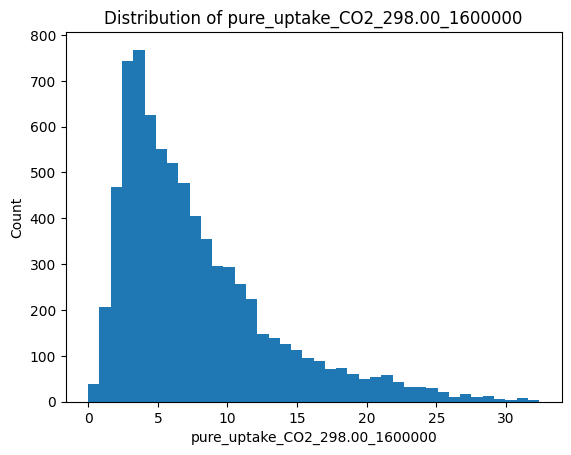

In [3]:
label = 'pure_uptake_CO2_298.00_1600000'
labelled_data_dir = 'CoRE2019_labelled_chem.csv'
df_labelled_hist = pd.read_csv(labelled_data_dir)

y = df_labelled_hist[label].dropna().values

plt.figure()
plt.hist(y, bins=40)
plt.title(f"Distribution of {label}")
plt.xlabel(label); plt.ylabel("Count")
plt.show()

## 7) Run the Experiment (CoRE2019, CO₂ Uptake @ High Pressure)

In this section we execute the full Bayesian Optimization loop using `bo_run`.

**Study context**
- **Dataset**: CoRE2019 MOF database.
- **Targets (label)**: High-pressure **CO₂ uptake** (here: `pure_uptake_CO2_298.00_1600000`).
- **Features in two attempts**:
  1. **Geometric features** computed with **Z++** (use the Z++-based CSVs).
  2. **Chemical descriptors** computed with **RACs** (use the RACs-based CSVs).
  
This tutorial cell currently points to the **RACs** variant (notice the filenames ending with `_chem.csv`).  
To repeat the run with **Z++ geometric features**, simply switch the two file paths to the corresponding `_geom.csv`.

### Configuration
- `nb_iterations=200` total BO steps (including the initial random acquisitions).
- `nb_initialization=10` random points to seed the GP.
- Acquisition function: `"EI"` (Expected Improvement).

> **Outputs saved**
> - The combined features+labels DataFrame is written to `df.csv` at the end of the run.
> - `ids_acquired` and (optionally) `explore_exploit_balance` are stored in `bo_res` for inspection.
> - The live plot in the previous step updates during the run; set up your notebook for continuous display (already handled in `bo_run`).


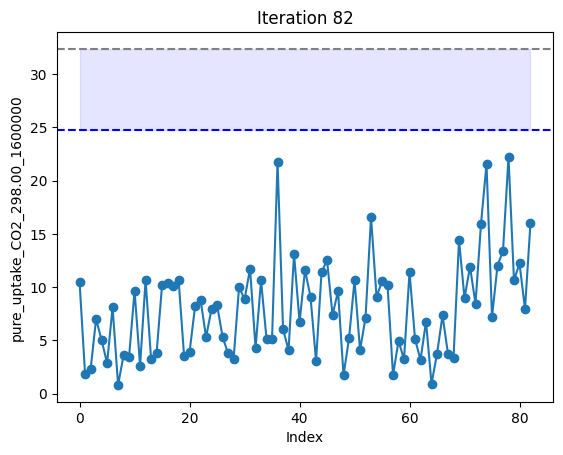

/usr/local/lib/python3.12/dist-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/usr/local/lib/python3.12/dist-packages/botorch/acquisition/analytic.py:337: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


In [ ]:
nb_iterations = 200
nb_initialization = 10
which_acquisition = "EI"
i = 1
seed_number = 42
labelled_data_dir = 'CoRE2019_labelled_chem.csv'
unlabelled_data_dir = 'CoRE2019_unlabelled_chem.csv'
label = 'pure_uptake_CO2_298.00_1600000'

print("# Mixtures in initialization:", nb_initialization)

bo_res = dict()
bo_res['ids_acquired']            = []
bo_res['explore_exploit_balance'] = []
store_explore_exploit_terms = True

print("\nRUN Started")
t0 = time.time()

df_X, df_y, ids_acquired, explore_exploit_balance = bo_run(labelled_data_dir, unlabelled_data_dir, nb_iterations,
                                                           nb_initialization, which_acquisition, store_explore_exploit_terms=True,
                                                           seed_number = 42, noise_ratio = 0.05, label = label)

# store results from this run.
bo_res['ids_acquired'].append(ids_acquired)
bo_res['explore_exploit_balance'].append(explore_exploit_balance)

print("took time t = ", (time.time() - t0) / 60, "min\n")
df = pd.concat([df_X, df_y], axis = 1)
df.to_csv('df.csv', index = True)




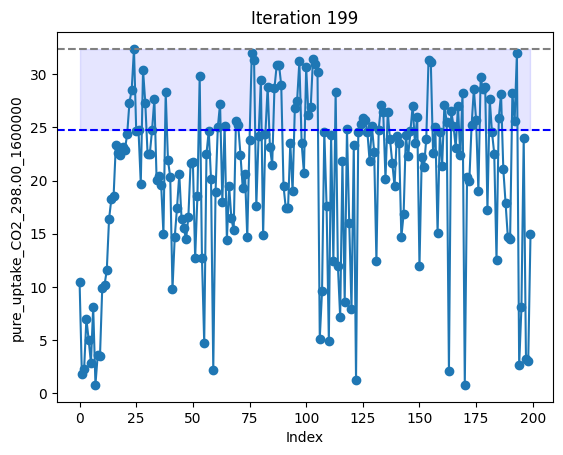

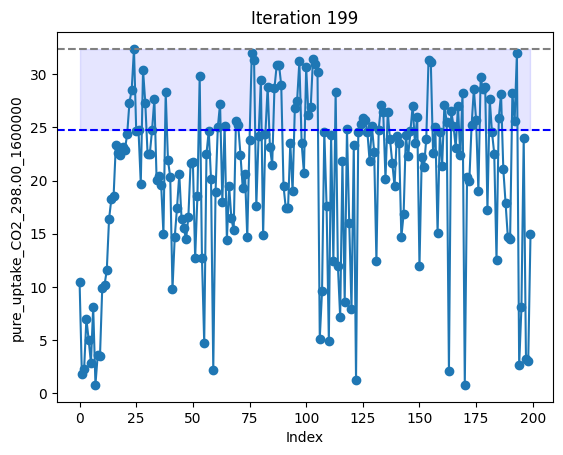

took time t =  3.720988198121389 min



In [6]:
nb_iterations = 200
nb_initialization = 10
which_acquisition = "EI"
i = 1
seed_number = 42
# base_dir = '../data/TF'
labelled_data_dir = 'CoRE2019_labelled_geom.csv'
unlabelled_data_dir = 'CoRE2019_unlabelled_geom.csv'
label = 'pure_uptake_CO2_298.00_1600000'


print("# Mixtures in initialization:", nb_initialization)

# store results here.
bo_res = dict()
bo_res['ids_acquired']            = []
bo_res['explore_exploit_balance'] = []
store_explore_exploit_terms = True

print("\nRUN Started")
t0 = time.time()

df_X, df_y, ids_acquired, explore_exploit_balance = bo_run(labelled_data_dir, unlabelled_data_dir, nb_iterations,
                                                           nb_initialization, which_acquisition, store_explore_exploit_terms=True,
                                                           seed_number = 42, noise_ratio = 0.05, label = label)

# store results from this run.
bo_res['ids_acquired'].append(ids_acquired)
bo_res['explore_exploit_balance'].append(explore_exploit_balance)

print("took time t = ", (time.time() - t0) / 60, "min\n")

df = pd.concat([df_X, df_y], axis = 1)
df.to_csv('df.csv', index = True)


